In [1]:
import os

import pickle

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from sklearn.metrics import roc_curve, auc
from matplotlib.ticker import ScalarFormatter


import tensorflow as tf
tf.config.list_physical_devices('GPU')

from keras.utils import Sequence,plot_model
from keras.models import load_model

#### CREAIAMO LE CLASSI MyGenerator PER FORNIRE IL DATASET AL MODELLO GIà DIVISO IN BATCHES #####

### MyGenerator ASSOCIA AD OGNI EVENTO ANCHE LA SUA LABEL IN MODO DA VALUTARE LE PRESTAZIONI DEL MODELLO (model.evaluate) ###

class MyGenerator_wLables(Sequence):
    
    def __init__(self,data_dir,labels_dir):
        self.data_dir=data_dir
        self.labels_dir=labels_dir
        self.labels_files=os.listdir(self.labels_dir)
        self.data_files=os.listdir(self.data_dir)
        
        # Assicuriamoci di eliminiare tutti i possibili file nascosti nella cartella dei dati e delle labels
        for i,data in enumerate(self.data_files):
            if data[0]=='.':
                self.data_files.pop(i)
                
        for i,labels in enumerate(self.labels_files):
            if data[0]=='.':
                self.labels_files.pop(i)
        
        with open(self.labels_dir+'/'+self.labels_files[0],'rb') as f:
            self.batch_size=len(pickle.load(f))

        self.indexes=np.arange(len(self.labels_files))
    
    def __len__(self):
        return len(self.data_files)

    def __getitem__(self,index):
        
        with open(self.data_dir+'/'+str(index)+'.pkl','rb') as f:
            batch_data=pickle.load(f)

        with open(self.labels_dir+'/'+str(index)+'.pkl','rb') as f:
            batch_labels=pickle.load(f)

        return np.array(batch_data),np.array(batch_labels)


### MyGenerator_jData RECUPERA SOLO GLI EVENTI DAL SET IN MODO CHE IL MODELLO POSSA PREDIRNE L'OUTPUT (model.predict) ###

class MyGnerator_jData(Sequence):

    def __init__(self,data_dir):
        self.data_dir=data_dir
        self.data_files=os.listdir(self.data_dir)

        # Assicuriamoci di eliminiare tutti i possibili file nascosti nella cartella dei dati e delle labels
        for i,data in enumerate(self.data_files):
            if data[0]=='.':
                self.data_files.pop(i)

    def __len__(self):
        return len(self.data_files)

    def __getitem__(self,index):
        
        with open(self.data_dir+'/'+str(index)+'.pkl','rb') as f:
            batch_data=pickle.load(f)

        return np.array(batch_data)

2024-11-29 12:25:52.222740: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-29 12:25:52.282537: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-29 12:25:52.286195: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
##### CARICHIAMO IL MODELLO bottle_depth_11_170 E CONTROLLIAMO SE I BUCHI E I PICCHI ANOMALI PRESENTI NELLE PREDICTION DEL TEST SET CI SONO ANCHE PER IL TRAIN E VALIDATION SET
arch='bottle'
#arch='funnel'
#arch='constant'
model_name=arch+'_depth_11_32'
model_path='fcNN/bottle/'+model_name+'/'+model_name+'_trained.h5'
model=load_model(model_path)

2024-11-29 12:25:52.333467: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-29 12:25:52.335777: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-29 12:25:52.337197: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-29 12:25:52.338491: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

In [3]:
#### CARICHIAMO I TRE DATASET CON RELATIVE LABEL ####
### QUESTI VANNO DATI A model.predict CHE PREDICE UN RISULTATO PER OGNI EVENTO NEL TEST-SET ###

test_generator_jData=MyGnerator_jData('test/test_norm_data')

### RECUPERIAMO TUTTE LE LABELS ###
num_lables=len(os.listdir('test/test_labels'))
test_labels=[]
for i in range(num_lables):
    with open('test/test_labels/'+str(i)+'.pkl','rb') as f:
        test_labels.extend(pickle.load(f))


train_generator_jData=MyGnerator_jData('train/train_norm_data')

### RECUPERIAMO TUTTE LE LABELS ###
num_lables=len(os.listdir('train/train_labels'))
train_labels=[]
for i in range(num_lables):
    with open('train/train_labels/'+str(i)+'.pkl','rb') as f:
        train_labels.extend(pickle.load(f))


validation_generator_jData=MyGnerator_jData('validation/validation_norm_data')

### RECUPERIAMO TUTTE LE LABELS ###
num_lables=len(os.listdir('validation/validation_labels'))
validation_labels=[]
for i in range(num_lables):
    with open('validation/validation_labels/'+str(i)+'.pkl','rb') as f:
        validation_labels.extend(pickle.load(f))

In [4]:
### Valutiamo le predizioni del modello sul test-set ###
test_predictions=model.predict(test_generator_jData,verbose=0)

### Utilizziamo le labels per dividere tra predizioni di Elettroni e di Protoni ###
test_predictions=test_predictions.flatten().tolist()
test_electrons_predictions=[]
test_protons_predictions=[]
### Se la label è 0 si tratta della prediction per un protone, se è 1 si tratta della prediction di un elettrone ###
for j,pred in enumerate(test_predictions):
    if test_labels[j]==0:
        test_protons_predictions.append(pred)
    elif test_labels[j]==1:
        test_electrons_predictions.append(pred)
    else:
        print('LABEL NOT VALID')
print(len(test_electrons_predictions))
print(len(test_protons_predictions))

2024-11-29 12:25:54.052680: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


765671
544603


In [5]:
### Valutiamo le predizioni del modello sul train-set ###
train_predictions=model.predict(train_generator_jData,verbose=0)

### Utilizziamo le labels per dividere tra predizioni di Elettroni e di Protoni ###
train_predictions=train_predictions.flatten().tolist()
train_electrons_predictions=[]
train_protons_predictions=[]
### Se la label è 0 si tratta della prediction per un protone, se è 1 si tratta della prediction di un elettrone ###
for j,pred in enumerate(train_predictions):
    if train_labels[j]==0:
        train_protons_predictions.append(pred)
    elif train_labels[j]==1:
        train_electrons_predictions.append(pred)
    else:
        print('LABEL NOT VALID')
print(len(train_electrons_predictions))
print(len(train_protons_predictions))

1276002
907672


In [6]:
### Valutiamo le predizioni del modello sul validation-set ###
validation_predictions=model.predict(validation_generator_jData,verbose=0)

### Utilizziamo le labels per dividere tra predizioni di Elettroni e di Protoni ###
validation_predictions=validation_predictions.flatten().tolist()
validation_electrons_predictions=[]
validation_protons_predictions=[]
### Se la label è 0 si tratta della prediction per un protone, se è 1 si tratta della prediction di un elettrone ###
for j,pred in enumerate(validation_predictions):
    if validation_labels[j]==0:
        validation_protons_predictions.append(pred)
    elif validation_labels[j]==1:
        validation_electrons_predictions.append(pred)
    else:
        print('LABEL NOT VALID')
print(len(validation_electrons_predictions))
print(len(validation_protons_predictions))

510448
363069


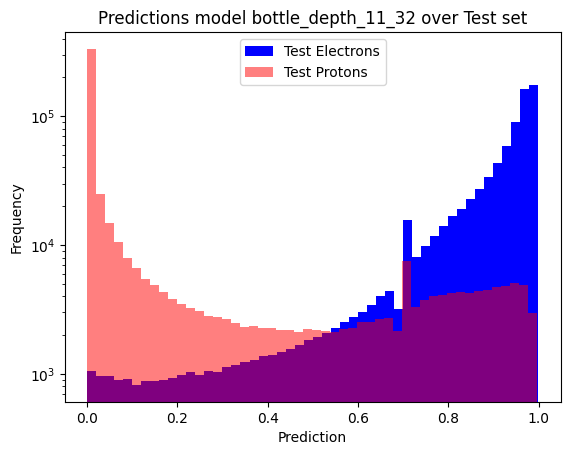

In [8]:
### Plottiamo le predictions per Elettroni e Protoni di Test ###
fig, ax=plt.subplots()
ax.hist(test_electrons_predictions,bins=50,color="blue",label="Test Electrons")
ax.hist(test_protons_predictions,bins=50,color="red",label="Test Protons",alpha=0.5)
ax.legend()
plt.xlabel('Prediction')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Predictions model '+model_name+' over Test set')
plt.show()

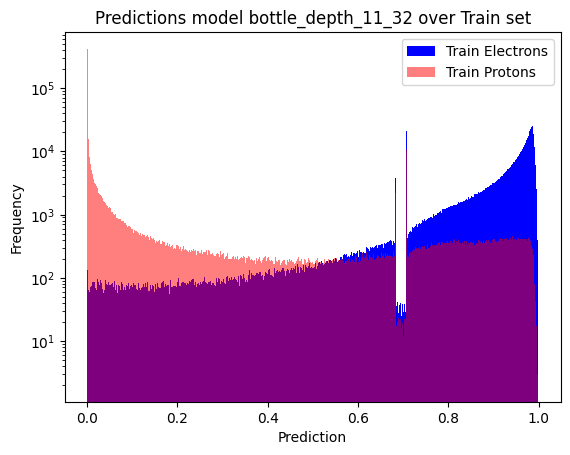

In [9]:
### Plottiamo le predictions per Elettroni e Protoni di Train ###
fig, ax=plt.subplots()
ax.hist(train_electrons_predictions,bins=1000,color="blue",label="Train Electrons")
ax.hist(train_protons_predictions,bins=1000,color="red",label="Train Protons",alpha=0.5)
ax.legend()
plt.xlabel('Prediction')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Predictions model '+model_name+' over Train set')
plt.show()

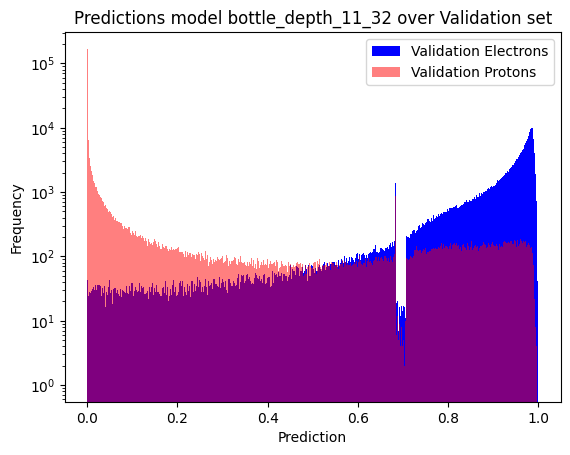

In [10]:
### Plottiamo le predictions per Elettroni e Protoni di Validation ###
fig, ax=plt.subplots()
ax.hist(validation_electrons_predictions,bins=1000,color="blue",label="Validation Electrons")
ax.hist(validation_protons_predictions,bins=1000,color="red",label="Validation Protons",alpha=0.5)
ax.legend()
plt.xlabel('Prediction')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Predictions model '+model_name+' over Validation set')
plt.show()

In [11]:
#### Plottiamo i pesi del modello ####
#### .get_weights() RESTITUISCE UNA LISTA CON GLI ELELMENTI PARI CHE CORRISPONDONO AI PESI E QUELLI DISPARI AI BIAS ###
#### OGNI ELEMENTO PARI è UNA LISTA DI LISTE UNA PER OGNI NEURONE DEL LAYER PRECEDENTE CON UN NUMERO DI ELELNTI PARI A QUELLI DEL LAYER SUCCESSIVO 
weights_biases = model.get_weights()
biases=[]
weights=[]
for i in range(len(weights_biases)):
    if i%2==0:
        weights.append(weights_biases[i])
    else:
        biases.append(weights_biases[i])

In [12]:
for i, weight in enumerate(weights):
    if np.isnan(weight).any():
        print(f'NaN trovato nei pesi del layer {i+1}')
    else:
        print(f'Layer {i+1} senza NaN')

Layer 1 senza NaN
Layer 2 senza NaN
Layer 3 senza NaN
Layer 4 senza NaN
Layer 5 senza NaN
Layer 6 senza NaN
Layer 7 senza NaN
Layer 8 senza NaN
Layer 9 senza NaN
Layer 10 senza NaN


In [13]:
for i,bias  in enumerate(biases):
    if np.isnan(bias).any():
        print(f'NaN trovato nei pesi del layer {i+1}')
    else:
        print(f'Layer {i+1} senza NaN')

Layer 1 senza NaN
Layer 2 senza NaN
Layer 3 senza NaN
Layer 4 senza NaN
Layer 5 senza NaN
Layer 6 senza NaN
Layer 7 senza NaN
Layer 8 senza NaN
Layer 9 senza NaN
Layer 10 senza NaN


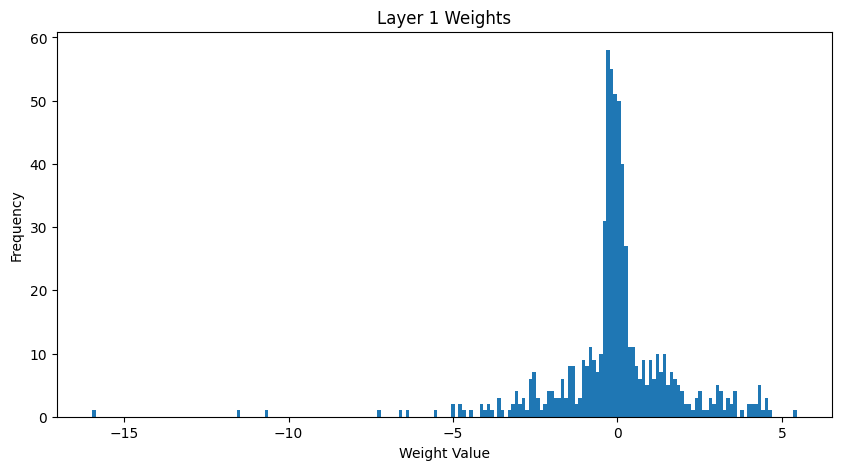

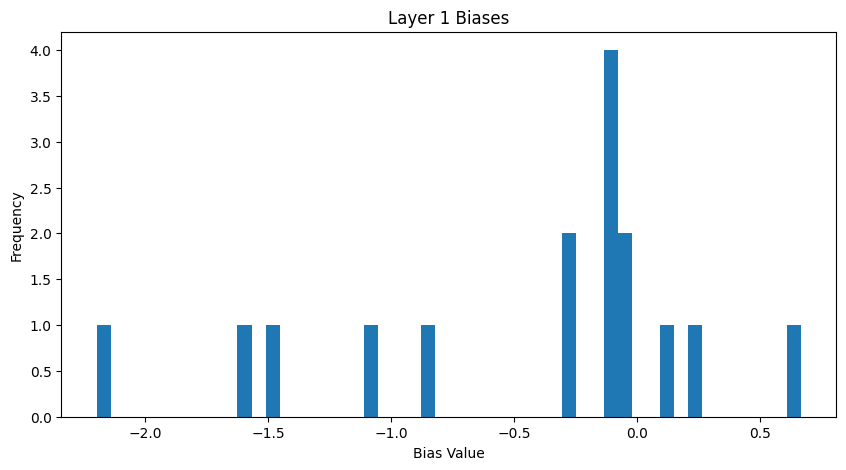

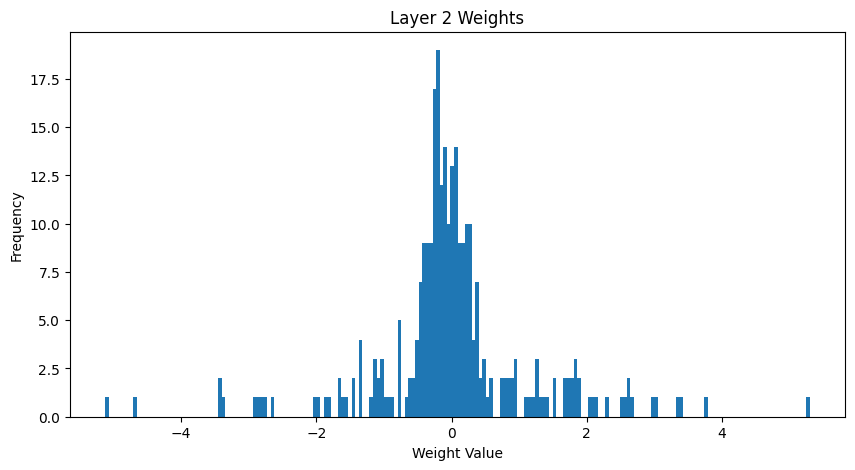

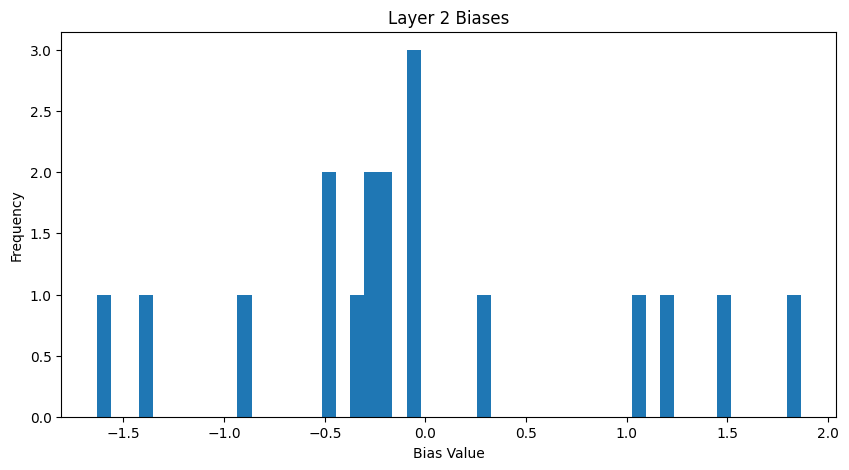

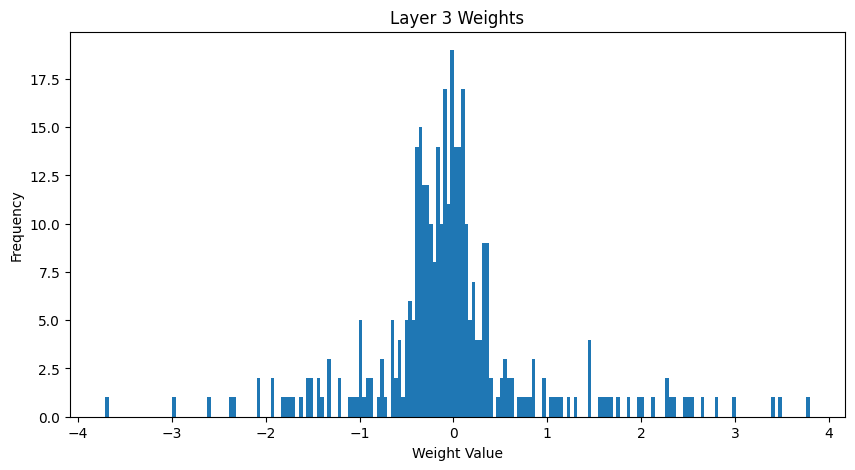

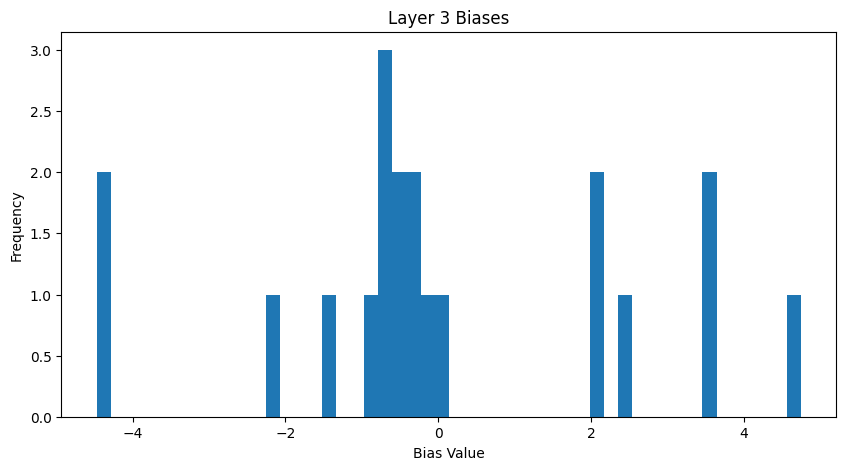

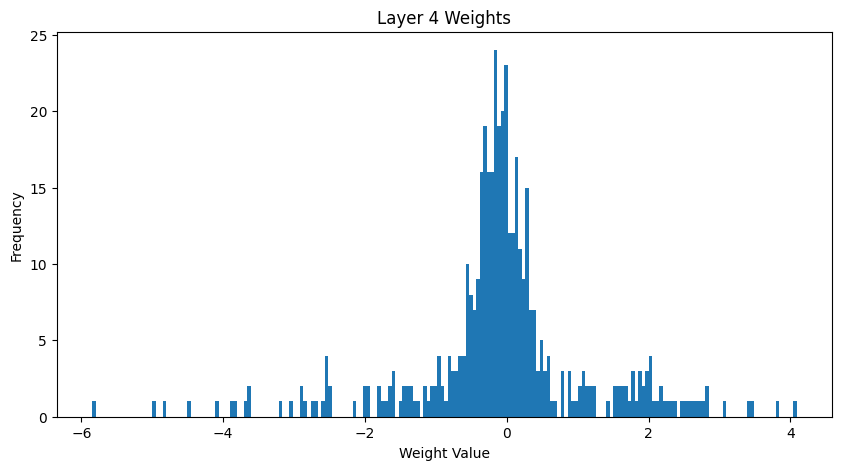

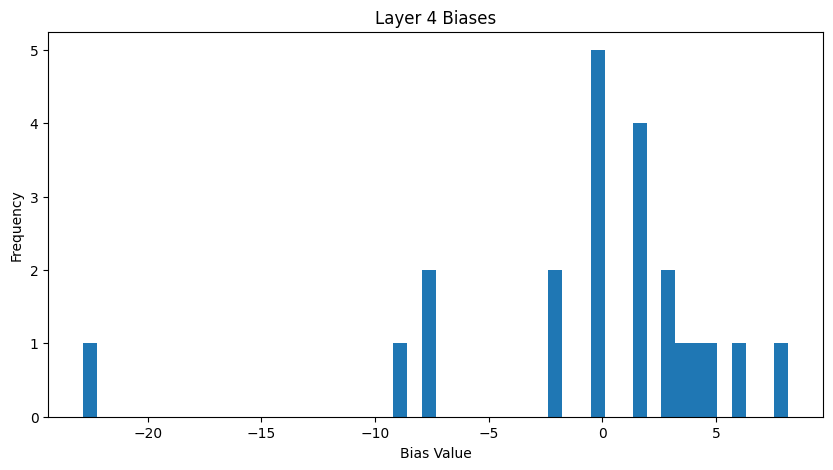

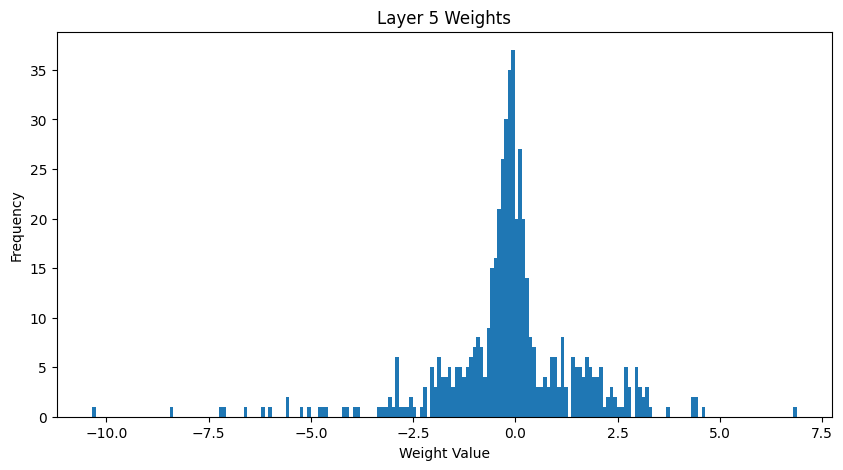

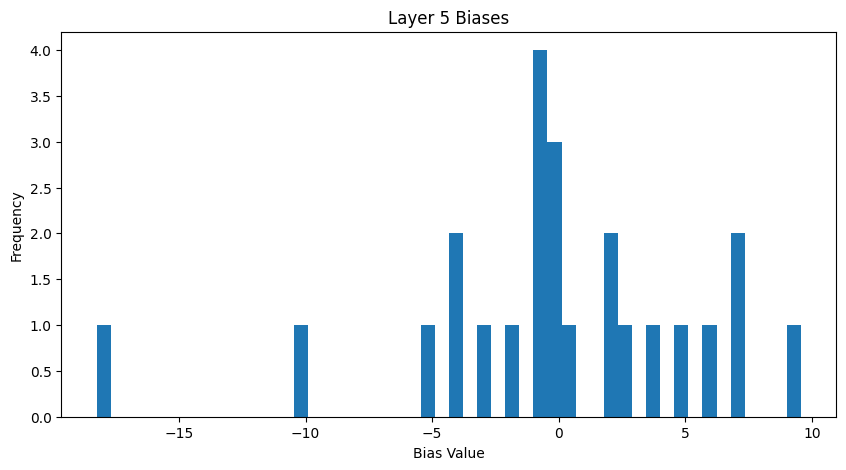

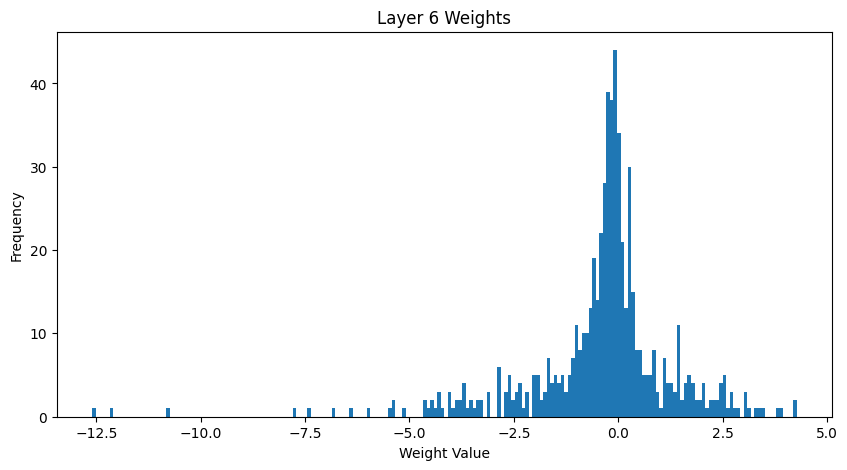

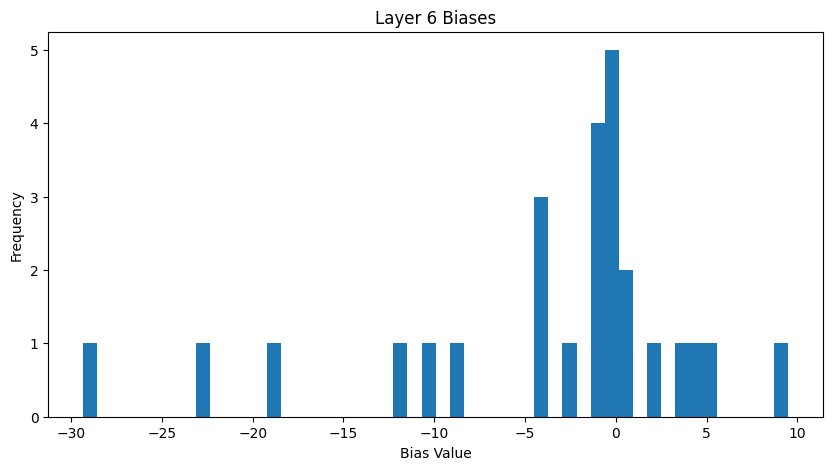

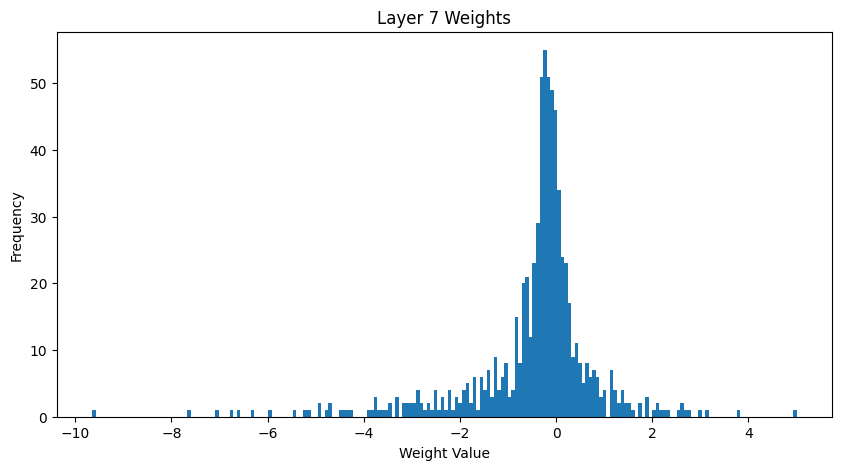

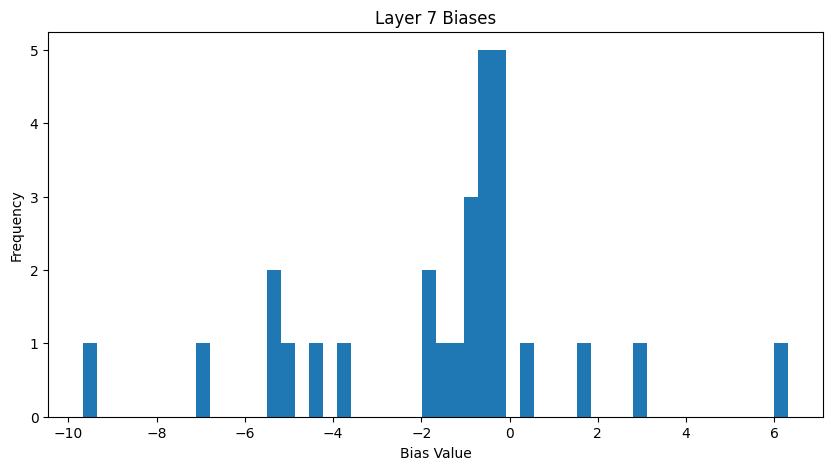

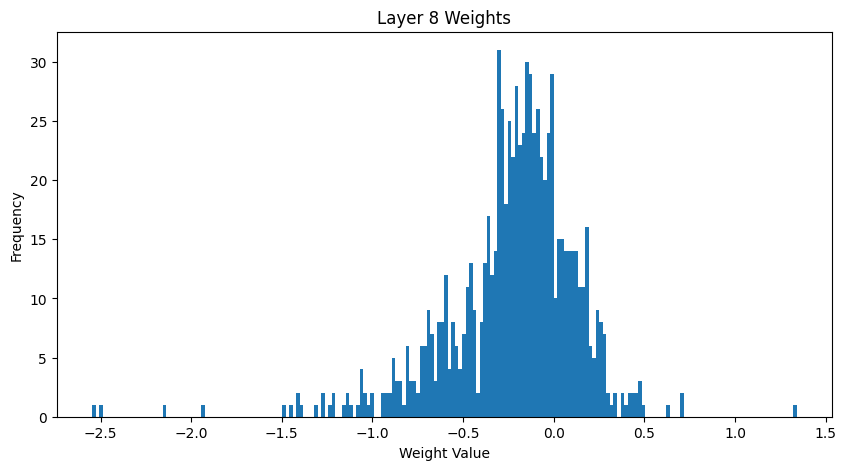

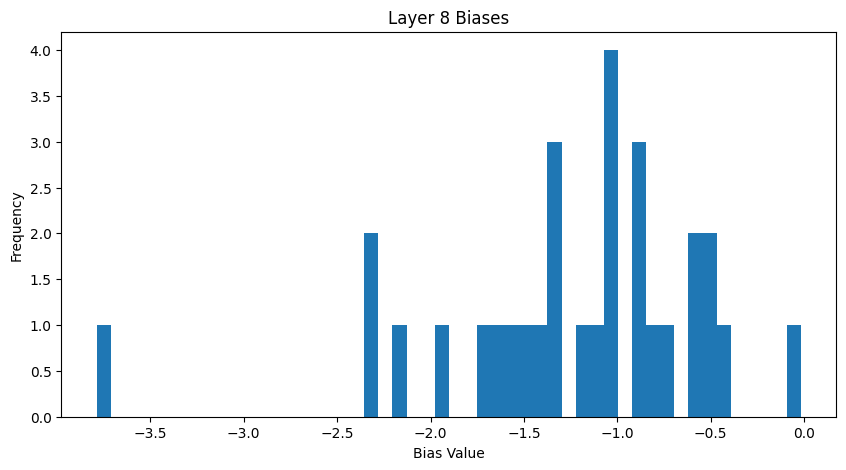

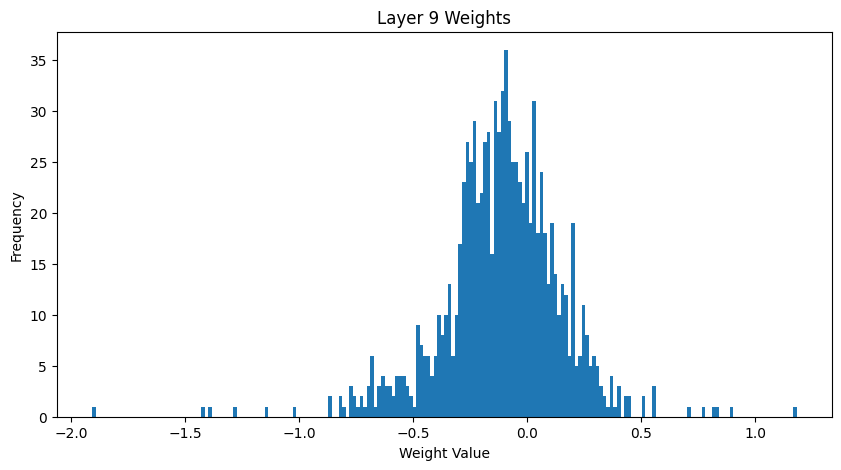

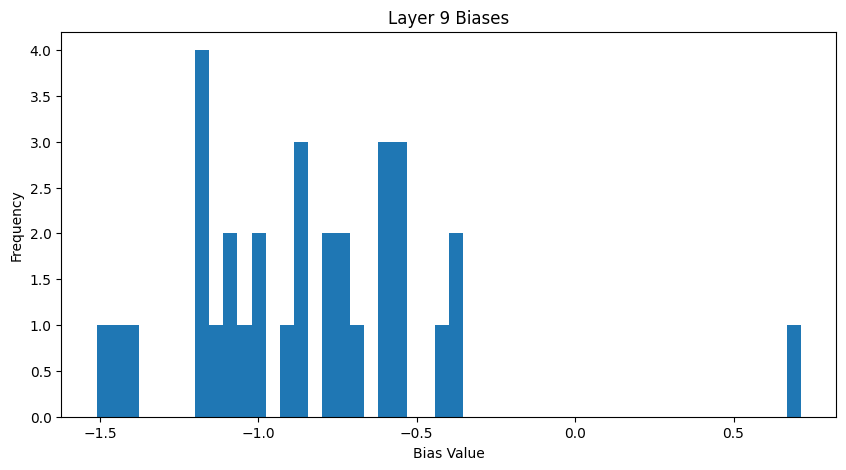

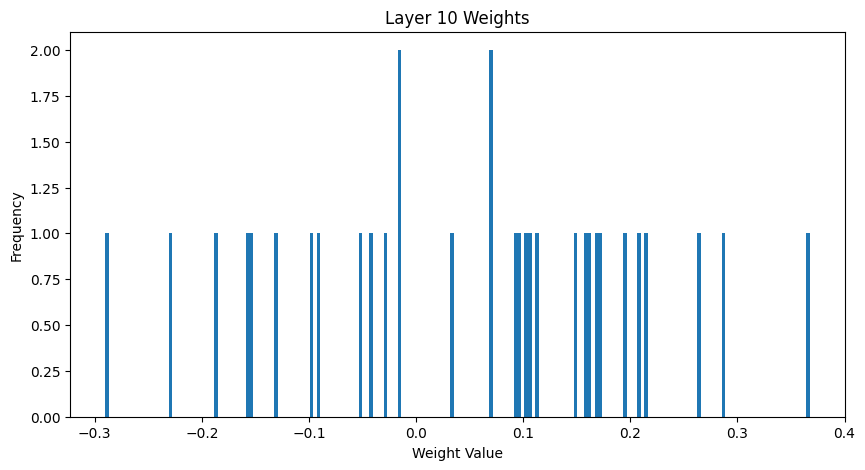

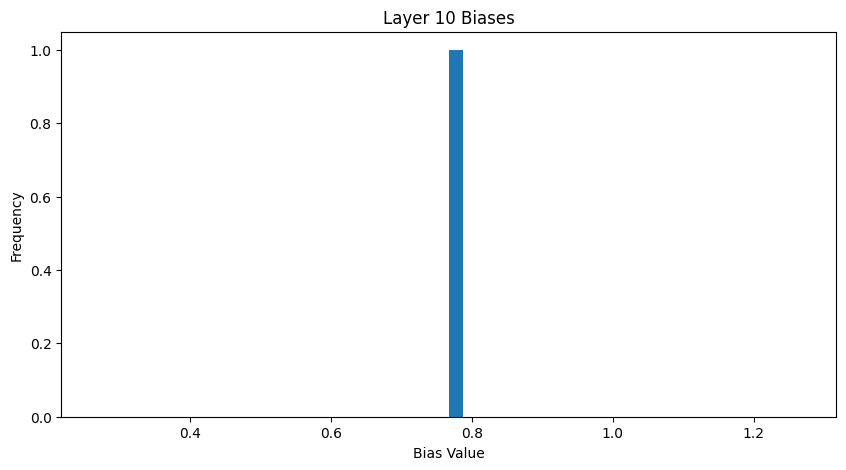

In [14]:
#### Plottiamo Pesi e Biases layer per layer ####
for i in range(len(weights)):
    plt.figure(figsize=(10, 5))
    plt.hist(weights[i].flatten(), bins=200)
    plt.title(f'Layer {i+1} Weights')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.hist(biases[i], bins=50)
    plt.title(f'Layer {i+1} Biases')
    plt.xlabel('Bias Value')
    plt.ylabel('Frequency')
    plt.show()

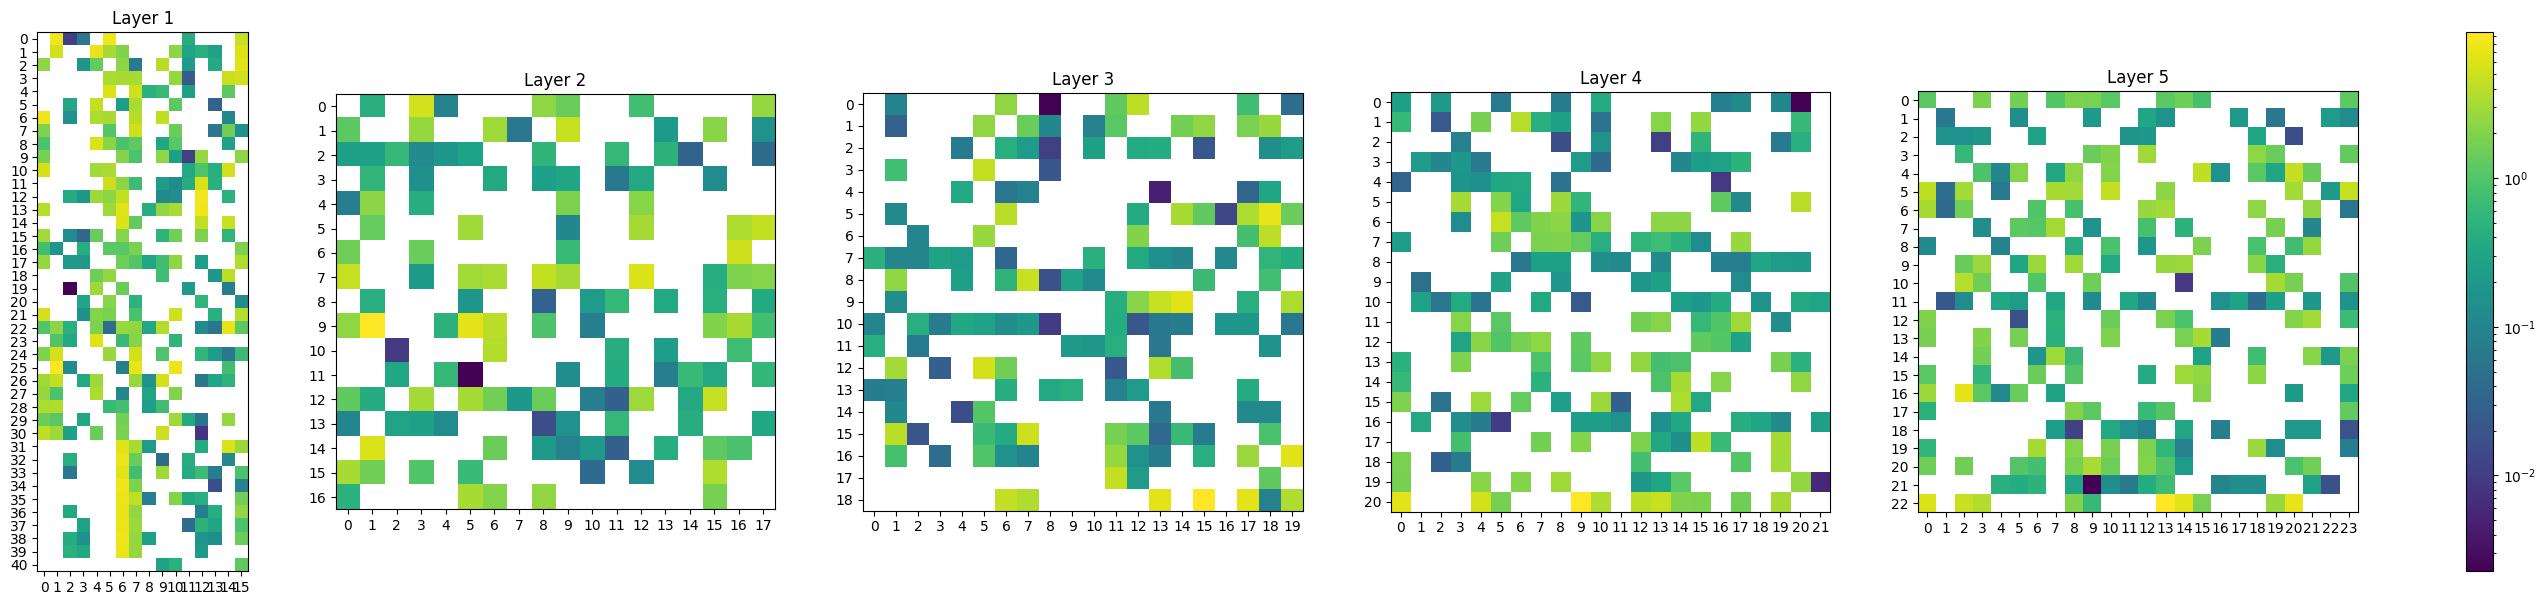

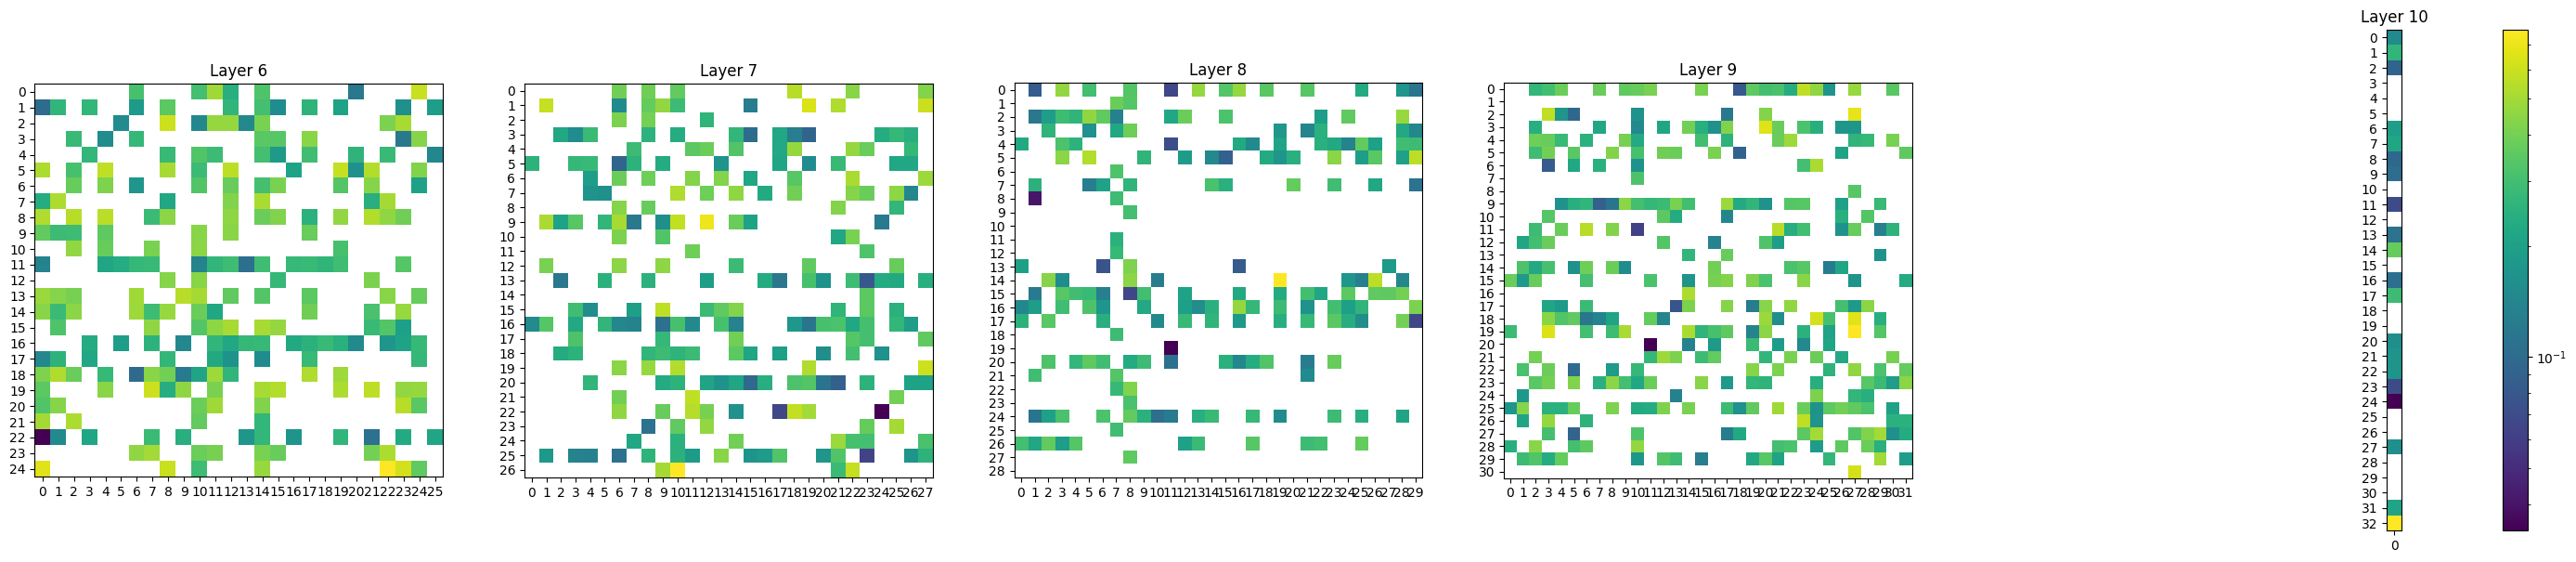

In [15]:
# Numero di immagini per figura
images_per_figure = 5
# Crea le figure e gli assi per i sottoplot
for i in range(0, len(weights), images_per_figure):
    fig, axs = plt.subplots(1, images_per_figure, figsize=(7 * images_per_figure, 7))
    
    # Se c'è solo un asse, mettilo in una lista per iterare
    if images_per_figure == 1:
        axs = [axs]
    
    for j in range(images_per_figure):
        if i + j < len(weights):
            layer_i = np.vstack([weights[i + j], biases[i + j]])
            im = axs[j].imshow(layer_i, cmap='viridis', norm=LogNorm(), interpolation='none')
            axs[j].set_xticks(np.arange(len(layer_i[0])))
            axs[j].set_yticks(np.arange(len(layer_i)))
            axs[j].set_title(f'Layer {i + j + 1}')
    
    # Aggiungi una colorbar comune
    fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
    
    # Mostra il plot
    plt.show()